# Final Project and Certification: Intermediate
Aria Yudhistira Dasopang / Batch 28    

In [2]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
# Read dataframe
df_sales = pd.read_csv('SalesTransactionv4a-230918-164139.csv')

## 1. Data Preparation

### 1.1 Data Cleaning

In [4]:
# Buang semua transaksi yang memiliki quantity negatif atau yang TransactionNo diawali dengan C
df_salesnoc = (df_sales[df_sales['TransactionNo'].str[0]!='C']).copy()

In [5]:
# Urutan hari dan bulan
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
quarter_order = ["Q1", "Q2", "Q3", "Q4"]

In [6]:
# Ubah tipe data
int_cols = ["Quantity"]
float_cols = ["Price"]
date_cols = ["Date"]
str_cols = [
    "TransactionNo", "ProductNo", "ProductName", "Country", "CustomerNo"
] 

for col in int_cols:
    df_salesnoc[col] = pd.to_numeric(df_salesnoc[col], errors = "coerce").astype("Int64")
for col in float_cols:
    df_salesnoc[col] = pd.to_numeric(df_salesnoc[col], errors = "coerce").astype("float")
for col in date_cols:
    df_salesnoc[col] = pd.to_datetime(df_salesnoc[col], errors = "coerce")
for col in str_cols:
    df_salesnoc[col] = df_salesnoc[col].astype("string")

In [7]:
# Deteksi outlier
df_salesnoc['Quantity'].sort_values(ascending=False).head(10)

142       80995
473985    74215
41367     12540
117790     4800
331834     4300
438495     3906
269982     3186
483801     3114
376379     3114
105437     3000
Name: Quantity, dtype: Int64

In [8]:
df_salesnoc['Quantity'].describe()

count      527765.0
mean      10.594674
std      156.786646
min             1.0
25%             1.0
50%             3.0
75%            11.0
max         80995.0
Name: Quantity, dtype: Float64

Terdapat 3  dari 527.765 baris transaksi memiliki kuantitas pembelian >10000 per produk, baris ini akan dianggap sebagai outlier dan tidak digunakan dalam analisis. Adapun baris transaksi dengan kuantitas pembelian 100-10000 akan dianggap sebagai transaksi bulk dan dipisahkan dari data normal agar hasil analisis tidak bias.

In [9]:
# Remove outlier
df_bersih = (df_salesnoc[df_salesnoc['Quantity']<=10000]).copy()

In [10]:
df_bersih.info()

<class 'pandas.core.frame.DataFrame'>
Index: 527762 entries, 0 to 536324
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  527762 non-null  string        
 1   Date           527762 non-null  datetime64[ns]
 2   ProductNo      527762 non-null  string        
 3   ProductName    527762 non-null  string        
 4   Price          527762 non-null  float64       
 5   Quantity       527762 non-null  Int64         
 6   CustomerNo     527761 non-null  string        
 7   Country        527762 non-null  string        
dtypes: Int64(1), datetime64[ns](1), float64(1), string(5)
memory usage: 36.7 MB


In [11]:
# Data Filtering: fokus pada transaksi tahun utuh 2019
df_bersih_2019 = df_bersih[df_bersih['Date'].dt.year == 2019].copy()

In [12]:
# Pembuatan threshold segmentasi transaksi Bulk dan Normal
cektreshold_quantity = df_bersih_2019.groupby('TransactionNo')['Quantity'].sum().reset_index()

In [13]:
# Threshold dibuat berdasarkan batas kuantil 90%
qty_thresh = cektreshold_quantity['Quantity'].quantile(0.9)
qty_thresh

np.float64(536.0)

In [14]:
# Labelling per baris
cektreshold_quantity['TransactionType'] = cektreshold_quantity['Quantity'].apply(
    lambda x: 'Bulk' if x > qty_thresh else 'Normal'
)

In [15]:
# Aplikasi label Bulk dan Normal ke dataframe induk
df_bersih_2019 = df_bersih.merge(
    cektreshold_quantity[['TransactionNo', 'TransactionType']],
    on='TransactionNo',
    how='left'
)

In [16]:
# Filtering Data Normal dan Bulk. Data yang akan dianalisis adalah dataframe normal (94% dari keseluruhan data valid).
df_normal = df_bersih_2019[df_bersih_2019['TransactionType']=='Normal'].copy()
df_bulk = df_bersih_2019[df_bersih_2019['TransactionType']=='Bulk'].copy()

## AKSES NOTEBOOK DATA BULK
Notebook kedua untuk segmen Bulk bisa diakses di sini:  
[Klik untuk membuka notebook Bulk](./Notebook_Intermediate_Bulk.ipynb)

In [17]:
df_bersih_2019['Quantity'].describe()

count     527762.0
mean     10.276882
std      37.740537
min            1.0
25%            1.0
50%            3.0
75%           11.0
max         4800.0
Name: Quantity, dtype: Float64

In [18]:
df_normal['Quantity'].describe()

count     357899.0
mean      7.738613
std      14.350303
min            1.0
25%            1.0
50%            4.0
75%           10.0
max          512.0
Name: Quantity, dtype: Float64

In [19]:
df_bulk['Quantity'].describe()

count     128446.0
mean     17.868972
std      68.986303
min            1.0
25%            1.0
50%            4.0
75%           12.0
max         4800.0
Name: Quantity, dtype: Float64

In [20]:
# Feature Engineering: penambahan kolom
df_normal['TotalRevenue'] = (df_normal['Price']) * (df_normal['Quantity'])
df_normal['PurchaseMonth'] = df_normal['Date'].dt.strftime("%B")
df_normal['PurchaseDay'] = df_normal['Date'].dt.strftime("%A")
df_normal['Quarter'] = df_normal['Date'].dt.quarter

### 1.2 Statistik Deskriptif

In [21]:
data = {
    'Metrik': [
        'Jumlah customer',
        'Jumlah transaksi unik', 
        'Jumlah baris',
        'Jumlah produk',
        'Jumlah country',
        'Transaksi awal',
        'Transaksi akhir'
    ],
    'All': [
        df_bersih['CustomerNo'].nunique(),
        df_bersih['TransactionNo'].nunique(),
        df_bersih['TransactionNo'].count(),
        df_bersih['ProductNo'].nunique(),
        df_bersih['Country'].nunique(),
        df_bersih['Date'].min().date(),
        df_bersih['Date'].max().date()
    ],
    'Normal': [
        df_normal['CustomerNo'].nunique(),
        df_normal['TransactionNo'].nunique(),
        df_normal['TransactionNo'].count(),
        df_normal['ProductNo'].nunique(),
        df_normal['Country'].nunique(),
        df_normal['Date'].min().date(),
        df_normal['Date'].max().date()
    ],
    'Bulk': [
        df_bulk['CustomerNo'].nunique(),
        df_bulk['TransactionNo'].nunique(),
        df_bulk['TransactionNo'].count(),
        df_bulk['ProductNo'].nunique(),
        df_bulk['Country'].nunique(),
        df_bulk['Date'].min().date(),
        df_bulk['Date'].max().date()
    ]
}

df_summary = pd.DataFrame(data)
print(df_summary.to_string(index=False))

               Metrik        All     Normal       Bulk
      Jumlah customer       4716       4388        862
Jumlah transaksi unik      19787      16414       1821
         Jumlah baris     527762     357899     128446
        Jumlah produk       3752       3621       3365
       Jumlah country         38         36         26
       Transaksi awal 2018-12-01 2019-01-04 2019-01-04
      Transaksi akhir 2019-12-09 2019-12-09 2019-12-09


## 2. Exploratory Analysis

### 2.1 Customer

#### 2.1.1 Segmentasi Customer

Segmentasi customer ditentukan berdasarkan total revenue dengan metode kuartil. Seluruh customer diurutkan menurut total revenue, kemudian dibagi ke dalam 4 kelompok (kuartil) sesuai urutan tersebut.

In [22]:
value_cust = df_normal.groupby('CustomerNo')['TotalRevenue'].sum().reset_index()

In [23]:
value_cust = value_cust.sort_values('TotalRevenue', ascending=False)

In [24]:
value_cust.to_csv('Nvalue_cust')

In [25]:
value_cust_quantiles = value_cust['TotalRevenue'].quantile([0.25, 0.50, 0.75]).to_dict()

In [26]:
def segment_monetary(M):
    if M < value_cust_quantiles[0.25]:
        return 'Low'
    elif M < value_cust_quantiles[0.50]:
        return 'Mid'
    elif M < value_cust_quantiles[0.75]:
        return 'High'
    else:
        return 'Top'

In [27]:
value_cust['MonetarySegment'] = value_cust['TotalRevenue'].apply(segment_monetary)

In [28]:
customer_revenue_segmented = value_cust.groupby('MonetarySegment')['TotalRevenue'].sum().round()

In [29]:
# Aplikasi label segmen ke dataframe normal
df_normal = df_normal.merge(value_cust[['CustomerNo', 'MonetarySegment']], on='CustomerNo', how='left')

In [30]:
# Mmebuat dictionary df agar memudahkan analisis pada segmen tertentu
df_normal_groupedc = dict(list(df_normal.groupby('MonetarySegment')))

In [31]:
profitable_segment = value_cust.groupby('MonetarySegment').agg(
    TotalRevenue = ('TotalRevenue', 'sum'),
    Customer = ('CustomerNo', 'nunique')
).reset_index().sort_values('TotalRevenue', ascending=False)

In [32]:
Total_All_Revenues = df_normal['TotalRevenue'].sum()

In [33]:
Total_All_Revenues

np.float64(31288319.460000005)

In [34]:
profitable_segment['Percentage'] = ((profitable_segment['TotalRevenue']/Total_All_Revenues).round(2)) * 100

In [35]:
# Persentase kontribusi revenue tiap segmen
profitable_segment

,MonetarySegment,TotalRevenue,Customer,Percentage
3,Top,21285890.99,1097,68.0
0,High,6245784.28,1097,20.0
2,Mid,2847667.39,1097,9.0
1,Low,908894.8,1097,3.0


#### 2.1.2 Konsentrasi Kontribusi Revenue

In [36]:
value_cust_top = value_cust[value_cust['MonetarySegment']=='Top'].copy().sort_values('TotalRevenue', ascending=False).reset_index(drop=True)

In [37]:
# Memberi label decile tiap customer Top
value_cust_top["decile"] = pd.qcut(value_cust_top.index, 10, labels=[f"{i*10+1}-{(i+1)*10}%" for i in range(10)])

In [38]:
# Menghitung total revenue tiap decile
revenue_by_decile = value_cust_top.groupby("decile", observed=False)["TotalRevenue"].sum().reset_index()

In [39]:
# Menghitung persentase kontribusi tiap decile
total_rev = value_cust_top["TotalRevenue"].sum()
revenue_by_decile["%_of_total"] = revenue_by_decile["TotalRevenue"] / total_rev * 100

In [40]:
revenue_by_decile

,decile,TotalRevenue,%_of_total
0,1-10%,6364949.36,29.902198
1,11-20%,3083510.24,14.486169
2,21-30%,2296768.24,10.790097
3,31-40%,1930269.71,9.068306
4,41-50%,1673000.08,7.859667
5,51-60%,1462889.19,6.872577
6,61-70%,1301427.35,6.114037
7,71-80%,1162262.42,5.460248
8,81-90%,1051691.12,4.94079
9,91-100%,959123.28,4.505911


Kontribusi revenue untuk segmen customer "Top" terkonsentrasi pada 30% customer teratas, yang menyumbang sekitar 60% dari total revenue segmen. Jika dibandingkan dengan prinsip Pareto 80/20, tingkat konsentrasi ini masih tergolong wajar dan tidak terlalu timpang.

#### 2.1.3 Pertumbuhan Tiap Segmen Customer

In [41]:
monetary_segment_growth = df_normal.groupby(['MonetarySegment', 'PurchaseMonth'], observed=False)['TotalRevenue'].sum().reset_index()

In [42]:
monetary_segment_growth['PurchaseMonth'] = pd.Categorical(
    monetary_segment_growth['PurchaseMonth'],
    categories = month_order,
    ordered = True
)

In [43]:
monetary_segment_growth = monetary_segment_growth.sort_values(['MonetarySegment', 'PurchaseMonth'], ascending=True)

In [44]:
monetary_segment_growth['GrowthPct'] = monetary_segment_growth.groupby('MonetarySegment')['TotalRevenue'].pct_change() * 100

In [45]:
cust_seg_growth_avg = monetary_segment_growth.groupby('MonetarySegment')['GrowthPct'].mean()

In [46]:
# Rata-rata pertumbuhan nilai transaksi tiap segmen customer secara kuartalan 
cust_seg_growth_avg

MonetarySegment
High    3.795301
Low     7.537908
Mid     9.585433
Top     1.364224
Name: GrowthPct, dtype: Float64

Pertumbuhan nilai transaksi segmen customer kuartalan mengindikasikan bahwa Customer Top cenderung lebih stabil dalam mengeluarkan uang untuk bertransaksi. Sebaliknya, Customer Mid nampak memiliki peningkatan revenue dengan rata-rata pertumbuhan nilai transaksi sebesar 23% setiap kuartalnya. Potensi ini akan dianalisis lebih dalam dengan deep dive pada AOV customer untuk menentukan strategi yang tepat. 

#### 2.1.4 Customer Segment Distribution by Country

In [47]:
cust_seg_country = df_normal.groupby(['MonetarySegment', 'Country'])['CustomerNo'].nunique().reset_index()

In [48]:
cust_seg_country_pivot = cust_seg_country.pivot_table(index='Country', columns='MonetarySegment', values='CustomerNo')

In [49]:
cust_seg_country_pivot = cust_seg_country_pivot.sort_values(['Top', 'High', 'Mid', 'Low'], ascending=False)

In [50]:
cust_seg_country_pivot = cust_seg_country_pivot.reindex(columns=['Top', 'High', 'Mid', 'Low'])

In [51]:
cust_country = df_normal.groupby('Country')['CustomerNo'].nunique().reset_index(name='JumlahCustomer').sort_values('JumlahCustomer', ascending=False)

In [52]:
cust_seg_country_pivot = cust_seg_country_pivot.merge(cust_country, on='Country', how='left')

In [53]:
cust_seg_country_pivot

,Country,Top,High,Mid,Low,JumlahCustomer
0,United Kingdom,991.0,989.0,1003.0,1033.0,4016
1,Germany,31.0,21.0,26.0,7.0,85
2,France,28.0,22.0,20.0,13.0,83
3,Belgium,10.0,3.0,4.0,5.0,22
4,Spain,6.0,7.0,5.0,4.0,22
5,Switzerland,4.0,5.0,4.0,4.0,17
6,Australia,4.0,2.0,2.0,1.0,9
7,Netherlands,4.0,NaN,3.0,1.0,8
8,EIRE,3.0,6.0,2.0,1.0,12
9,Portugal,3.0,4.0,5.0,2.0,14


### 2.2 Produk

#### 2.2.1 Segmentasi Produk

Produk disegmentasi berdasarkan 2 ukuran:
- Volume transaksi = jumlah transaksi per produk (kuantitas dalam transaksi diabaikan).
- Total revenue = harga × kuantitas.

Kedua ukuran tersebut akan diklasifikasi berdasarkan batas-batas berikut.
- 20% teratas = High
- 20–80% = Normal
- 20% terbawah = Low

Segmentasi akhir ditentukan berdasarkan kombinasi kedua ukuran:
- Super Popular: High di volume & revenue.
- Popular: salah satu High, lainnya Normal.
- Low: keduanya Low.
- Normal: kombinasi lain.

Segmentasi Produk (Volume)

In [54]:
df_volume_product = df_normal.groupby('ProductName')['TransactionNo'].nunique().reset_index(name='BanyakTransaksi')

In [55]:
df_volume_product = df_volume_product.sort_values('BanyakTransaksi', ascending=False)

In [56]:
label_volume = ['High', 'Normal', 'Low']
proporsi_volume = [0.2, 0.6, 0.2]

In [57]:
total_baris_volume = len(df_volume_product)
counts_volume = [int(p * total_baris_volume) for p in proporsi_volume]

In [58]:
selisih_volume = total_baris_volume - sum(counts_volume)

In [59]:
if selisih_volume > 0:
    half_volume = selisih_volume // 2
    counts_volume[0] += half_volume
    counts_volume[-1] += selisih_volume - half_volume

In [60]:
segment_labels = []
for label_volume, counts_volume in zip(label_volume, counts_volume):
    segment_labels.extend([label_volume] * counts_volume)

In [61]:
df_volume_product['SegVolumeProduct'] = segment_labels

Segmentasi Produk (Revenue)

In [62]:
df_revenue_product = df_normal.groupby('ProductName')['TotalRevenue'].sum().reset_index(name='NilaiTransaksi')

In [63]:
df_revenue_product = df_revenue_product.sort_values('NilaiTransaksi', ascending=False)

In [64]:
label_revenue = ['High', 'Normal', 'Low']
proporsi_revenue = [0.2, 0.6, 0.2]

In [65]:
total_baris_revenue = len(df_revenue_product)
counts_revenue = [int(p * total_baris_revenue) for p in proporsi_revenue]

In [66]:
selisih_revenue = total_baris_revenue - sum(counts_revenue)

In [67]:
if selisih_revenue > 0:
    half_revenue = selisih_revenue // 2
    counts_revenue[0] += half_revenue
    counts_revenue[-1] += selisih_revenue - half_revenue

In [68]:
segment_labels_revenue = []
for label_revenue, counts_revenue in zip(label_revenue, counts_revenue):
    segment_labels_revenue.extend([label_revenue] * counts_revenue)

In [69]:
df_revenue_product['SegrevenueProduct'] = segment_labels_revenue

Segmentasi Produk (Final)

In [70]:
# Aplikasikan segmentasi volume dan revenue produk ke dataframe normal
df_normal = (df_normal
                .merge(df_volume_product[['ProductName','SegVolumeProduct']], on='ProductName', how='left')
                .merge(df_revenue_product[['ProductName', 'SegrevenueProduct']], on='ProductName', how='left'))

In [71]:
def segment(S):
    vol, val = S['SegVolumeProduct'], S['SegrevenueProduct']
    if vol == 'High' and val == 'High':
        return 'Super Popular'
    elif (vol == 'High' and val == 'Normal') or (vol == 'Normal' and val == 'High'):
        return 'Popular'
    elif vol == 'Low' and val == 'Low':
        return 'Low'
    else :
        return 'Normal'

In [72]:
# Aplikasikan segmentasi produk ke dataframe normal
df_normal['SegFinalProduct'] = df_normal.apply(segment, axis=1)

In [73]:
product_category = df_normal[['ProductName', 'SegFinalProduct']]

In [74]:
product_category = product_category.drop_duplicates(subset='ProductName', keep = 'first')

In [75]:
# Jumlah produk berdasarkan segmentasi final
product_category_sum = product_category['SegFinalProduct'].value_counts().reset_index()

#### 2.2.2 Product Segment Revenue Contribution

In [76]:
product_seg_rev = df_normal.groupby('SegFinalProduct')['TotalRevenue'].sum()

In [77]:
product_category_sum_rev = product_category_sum.merge(
    product_seg_rev,
    on = 'SegFinalProduct',
    how = 'left'
)

In [78]:
product_category_sum_rev['ARP'] = product_category_sum_rev['TotalRevenue']/product_category_sum_rev['count']

In [79]:
product_category_sum_rev

,SegFinalProduct,count,TotalRevenue,ARP
0,Normal,2129,7321318.2,3438.853077
1,Low,621,72151.78,116.186441
2,Super Popular,577,19652458.22,34059.719619
3,Popular,294,4242391.26,14429.902245


#### 2.2.3 Product Segment Sales by Customer Segment

In [80]:
product_cust_seg = df_normal.groupby(['MonetarySegment', 'SegFinalProduct'])['TransactionNo'].nunique().reset_index()

In [81]:
product_cust_seg_pivot = product_cust_seg.pivot_table(index='MonetarySegment', columns='SegFinalProduct', values='TransactionNo')

In [82]:
product_cust_seg_pivot

SegFinalProduct,Low,Normal,Popular,Super Popular
MonetarySegment,,,,
High,270.0,2744.0,2413.0,3127.0
Low,99.0,1066.0,789.0,1239.0
Mid,157.0,1709.0,1439.0,1926.0
Top,543.0,7727.0,6796.0,9258.0


#### 2.2.4 Seasonality Product Segment Sales by Day

In [83]:
day_seg_prod = df_normal.groupby(['SegFinalProduct', 'PurchaseDay'])['TransactionNo'].nunique().reset_index()

In [84]:
seasonality_day_seg_prod = day_seg_prod.pivot_table(index='PurchaseDay', columns = 'SegFinalProduct', values='TransactionNo').reset_index()

In [85]:
seasonality_day_seg_prod['PurchaseDay'] = pd.Categorical(
    seasonality_day_seg_prod['PurchaseDay'],
    categories = day_order,
    ordered = True
)

In [86]:
seasonality_day_seg_prod = seasonality_day_seg_prod.sort_values('PurchaseDay', ascending = True)

In [87]:
seasonality_day_seg_prod

SegFinalProduct,PurchaseDay,Low,Normal,Popular,Super Popular
1,Monday,152.0,2057.0,1766.0,2442.0
5,Wednesday,169.0,1659.0,1448.0,1862.0
4,Thursday,158.0,2064.0,1768.0,2403.0
0,Friday,200.0,2344.0,2055.0,2777.0
2,Saturday,191.0,2355.0,2012.0,2801.0
3,Sunday,199.0,2767.0,2388.0,3266.0


#### 2.2.5 Seasonality Product Segment Sales by Month

In [88]:
month_seg_prod = df_normal.groupby(['SegFinalProduct', 'PurchaseMonth'])['TransactionNo'].nunique().reset_index()

In [89]:
seasonality_month_seg_prod = month_seg_prod.pivot_table(index='PurchaseMonth', columns = 'SegFinalProduct', values='TransactionNo').reset_index()

In [90]:
seasonality_month_seg_prod['PurchaseMonth'] = pd.Categorical(
    seasonality_month_seg_prod['PurchaseMonth'],
    categories = month_order,
    ordered = True
)

In [91]:
seasonality_month_seg_prod = seasonality_month_seg_prod.sort_values('PurchaseMonth', ascending=True)
seasonality_month_seg_prod

SegFinalProduct,PurchaseMonth,Low,Normal,Popular,Super Popular
4,January,119.0,814.0,663.0,890.0
3,February,104.0,812.0,695.0,958.0
7,March,134.0,1114.0,887.0,1246.0
0,April,104.0,908.0,780.0,1078.0
8,May,90.0,1165.0,1055.0,1479.0
6,June,63.0,1102.0,973.0,1344.0
5,July,73.0,1002.0,862.0,1223.0
1,August,70.0,920.0,818.0,1136.0
11,September,76.0,1298.0,1141.0,1520.0
10,October,76.0,1495.0,1284.0,1647.0


#### 2.2.6 Country Product Segment Sales Distribution

In [92]:
country_seg_prod = df_normal.groupby(['SegFinalProduct', 'Country'])['TransactionNo'].nunique().reset_index()

In [93]:
country_seg_prod_pivot = country_seg_prod.pivot_table(index='Country', columns = 'SegFinalProduct', values='TransactionNo')

In [94]:
country_seg_prod_pivot['TotalSold'] = (
    country_seg_prod_pivot[['Low', 'Normal', 'Popular', 'Super Popular']]
    .sum(axis=1, skipna=True)
)

In [95]:
country_seg_prod_pivot = country_seg_prod_pivot.sort_values('TotalSold', ascending=False)

In [96]:
country_seg_prod_pivot.head(6)

SegFinalProduct,Low,Normal,Popular,Super Popular,TotalSold
Country,,,,,
United Kingdom,1020.0,12032.0,10420.0,14179.0,37651.0
Germany,12.0,325.0,260.0,359.0,956.0
France,4.0,286.0,243.0,327.0,860.0
EIRE,10.0,161.0,140.0,175.0,486.0
Belgium,2.0,72.0,66.0,85.0,225.0
Spain,6.0,57.0,45.0,62.0,170.0


### 2.3 Retensi

#### 2.3.1 Kohort Retensi
Matriks kohort retensi dibentuk dengan cara menentukan bulan akuisisi setiap customer berdasarkan tanggal transaksi pertamanya di periode 1 Januari–30 November 2019, lalu menghitung jumlah customer baru per bulan. Selanjutnya, untuk tiap kohort bulan akuisisi, dilacak berapa banyak dari customer tersebut yang kembali bertransaksi pada bulan-bulan berikutnya, sehingga menghasilkan tabel retensi yang menampilkan persentase customer yang bertahan dari bulan awal akuisisi hingga periode selanjutnya.

In [97]:
df_normal['CohortMonth'] = df_normal.groupby('CustomerNo')['Date'].transform('min').dt.to_period('M')

In [98]:
df_normal['MonthsAfterJoin'] = (
    (df_normal['Date'].dt.to_period('M') - df_normal['CohortMonth'])
    .apply(lambda x: x.n if pd.notna(x) else None)
)

In [99]:
matrik_kohort = (df_normal.groupby(['MonthsAfterJoin', 'CohortMonth'])['CustomerNo']
                 .nunique()
                 .reset_index()
                 .pivot_table(index='CohortMonth', columns='MonthsAfterJoin', values='CustomerNo')
                )

In [100]:
# Matrik retensi customer 2019
matrik_kohort

MonthsAfterJoin,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
CohortMonth,,,,,,,,,,,,
2019-01,747.0,252.0,304.0,278.0,313.0,300.0,267.0,258.0,298.0,289.0,352.0,176.0
2019-02,534.0,120.0,121.0,168.0,150.0,131.0,140.0,150.0,147.0,183.0,58.0,NaN
2019-03,591.0,102.0,147.0,129.0,131.0,99.0,146.0,133.0,170.0,66.0,NaN,NaN
2019-04,391.0,86.0,83.0,89.0,75.0,92.0,90.0,107.0,34.0,NaN,NaN,NaN
2019-05,385.0,72.0,64.0,72.0,81.0,84.0,101.0,33.0,NaN,NaN,NaN,NaN
2019-06,311.0,57.0,45.0,67.0,62.0,84.0,29.0,NaN,NaN,NaN,NaN,NaN
2019-07,223.0,36.0,39.0,46.0,62.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,189.0,38.0,43.0,40.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,286.0,67.0,99.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
matrik_kohort_percentage = (matrik_kohort.divide(matrik_kohort.iloc[:, 0], axis=0) * 100).round(2)

In [102]:
# Matrik retensi customer 2019 (persentase)
# matrik_kohort_percentage

#### 2.3.2 Customer Segment Retention

In [103]:
df_retention = df_normal[df_normal['MonthsAfterJoin'] < 12].copy()

In [104]:
df_rentention_view = df_retention.groupby(['MonthsAfterJoin', 'MonetarySegment'])['CustomerNo'].nunique().reset_index()

In [105]:
df_rentention_view_pivot = df_rentention_view.pivot_table(index='MonetarySegment', columns='MonthsAfterJoin', values='CustomerNo', aggfunc='sum').reset_index()

In [106]:
cseg_order = ['Top', 'High', 'Mid', 'Low']

df_rentention_view_pivot['MonetarySegment'] = pd.Categorical(
    df_rentention_view_pivot['MonetarySegment'],
    categories = cseg_order,
    ordered = True
)

In [107]:
df_rentention_view_pivot = df_rentention_view_pivot.sort_values('MonetarySegment', ascending=True)
df_rentention_view_pivot

MonthsAfterJoin,MonetarySegment,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
3,Top,1097,509,574,560,567,525,522,464,472,383,329,158
0,High,1097,240,248,235,203,188,160,153,115,92,55,12
2,Mid,1097,152,118,92,103,79,66,45,47,48,19,5
1,Low,1097,45,38,37,23,21,25,19,15,15,7,1


#### 2.3.3 Product Segment Repurchased

In [108]:
df_product_segment_repurchased = df_retention.groupby(['SegFinalProduct', 'MonthsAfterJoin'])['TransactionNo'].nunique().reset_index()

In [109]:
product_segment_repurchased_pivot = df_product_segment_repurchased.pivot_table(index='SegFinalProduct', columns='MonthsAfterJoin', values='TransactionNo', aggfunc='sum').reset_index()

In [110]:
pseg_order = ['Super Popular', 'Popular', 'Normal', 'Low']

product_segment_repurchased_pivot['SegFinalProduct'] = pd.Categorical(
    product_segment_repurchased_pivot['SegFinalProduct'],
    categories = pseg_order,
    ordered = True
)

In [111]:
product_segment_repurchased_pivot = product_segment_repurchased_pivot.sort_values('SegFinalProduct', ascending=True)
product_segment_repurchased_pivot

MonthsAfterJoin,SegFinalProduct,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
3,Super Popular,4763,1208,1307,1174,1247,1103,1046,930,945,812,784,231
2,Popular,3698,836,920,824,858,792,777,678,700,613,576,165
1,Normal,4312,1024,1096,924,1002,910,859,765,811,689,655,199
0,Low,511,106,81,60,62,41,43,52,42,28,37,6


### 2.4 Average Order Value (AOV)

#### 2.4.1 Tren Jumlah Transaksi Harian

In [112]:
tren_transaction_harian = df_normal.groupby('Date')['TransactionNo'].nunique().reset_index(name="JumlahTransaksi")

In [113]:
tren_transaction_harian['MAJumlahTransaksi'] = tren_transaction_harian['JumlahTransaksi'].rolling(window=14).mean().round(0)

In [114]:
tren_transaction_harian.to_csv('Ntren_transaction_harian')

Tren jumlah transaksi tiap segmen customer

In [115]:
tren_segment_transaksi = {}

In [116]:
for segment_name, segment_df in df_normal_groupedc.items():
    tren_transaksi = segment_df.groupby('Date')['TransactionNo'].nunique().reset_index(name="JumlahTransaksi")
    tren_transaksi['MAJumlahTransaksi'] = tren_transaksi['JumlahTransaksi'].rolling(window=14).mean().round(0)
    tren_segment_transaksi[segment_name] = tren_transaksi

In [117]:
tren_top_transaksi = tren_segment_transaksi['Top']
tren_high_transaksi = tren_segment_transaksi['High']
tren_mid_transaksi = tren_segment_transaksi['Mid']
tren_low_transaksi = tren_segment_transaksi['Low']

In [118]:
tren_top_transaksi.to_csv("tren_top_transaksi")
tren_high_transaksi.to_csv("tren_high_transaksi")
tren_mid_transaksi.to_csv("tren_mid_transaksi")
tren_low_transaksi.to_csv("tren_low_transaksi")

#### 2.4.2 Tren Revenue Harian

In [119]:
tren_sales_harian_revenue = df_normal.groupby('Date')['TotalRevenue'].sum().reset_index()

In [120]:
tren_sales_harian_revenue['MATotalRevenue'] = tren_sales_harian_revenue['TotalRevenue'].rolling(window=14).mean().round(0)

In [121]:
tren_sales_harian_revenue.to_csv('Ntren_sales_harian_revenue')

Tren revenue harian tiap segmen customer

In [122]:
tren_segment_revenue = {}

In [123]:
for segment_name, segment_df in df_normal_groupedc.items():
    tren_revenue = segment_df.groupby('Date')['TotalRevenue'].sum().reset_index(name="Revenue")
    tren_revenue['MARevenue'] = tren_revenue['Revenue'].rolling(window=14).mean().round(0)
    tren_segment_revenue[segment_name] = tren_revenue

In [124]:
tren_top_revenue = tren_segment_revenue['Top']
tren_high_revenue = tren_segment_revenue['High']
tren_mid_revenue = tren_segment_revenue['Mid']
tren_low_revenue = tren_segment_revenue['Low']

In [125]:
tren_top_revenue.to_csv("tren_top_revenue")
tren_high_revenue.to_csv("tren_high_revenue")
tren_mid_revenue.to_csv("tren_mid_revenue")
tren_low_revenue.to_csv("tren_low_revenue")

#### 2.4.3 Tren AOV Harian

In [126]:
df_tren_aov_harian = df_normal.groupby(['TransactionNo','Date'])['TotalRevenue'].sum().reset_index()

In [127]:
tren_aov_harian = df_tren_aov_harian.groupby('Date')['TotalRevenue'].mean().round(0).reset_index(name='AvgAOV')

In [128]:
tren_aov_harian['MAAvgAOV'] = tren_aov_harian['AvgAOV'].rolling(window=14).mean().round(0)

In [129]:
tren_aov_harian.to_csv('Ntren_aov_harian')

Tren AOV harian tiap segmen customer

In [130]:
tren_segment_aov = {}

In [131]:
for segment_name, segment_df in df_normal_groupedc.items():
    daily_stats = segment_df.groupby('Date').agg({
        'TotalRevenue': 'sum',
        'TransactionNo': 'nunique'
    }).reset_index()
    daily_stats.columns = ['Date', 'TotalRevenue', 'JumlahTransaksi']
    
    daily_stats['AOV'] = daily_stats['TotalRevenue'] / daily_stats['JumlahTransaksi']
    daily_stats['MA_AOV'] = daily_stats['AOV'].rolling(window=14).mean().round(0)
    
    tren_segment_aov[segment_name] = daily_stats

In [132]:
tren_top_aov = tren_segment_aov['Top']
tren_high_aov = tren_segment_aov['High']
tren_mid_aov = tren_segment_aov['Mid']
tren_low_aov = tren_segment_aov['Low']

In [133]:
tren_top_aov.to_csv("tren_top_aov")
tren_high_aov.to_csv("tren_high_aov")
tren_mid_aov.to_csv("tren_mid_aov")
tren_low_aov.to_csv("tren_low_aov")

#### 2.4.4 Tren AOV Bulanan

In [134]:
df_tren_aov_bulanan = df_normal.groupby(['TransactionNo','PurchaseMonth'])['TotalRevenue'].sum().reset_index()

In [135]:
tren_aov_bulanan = df_tren_aov_bulanan.groupby('PurchaseMonth')['TotalRevenue'].mean().round(0).reset_index(name='AOV')

In [136]:
tren_aov_bulanan['PurchaseMonth'] = tren_aov_bulanan['PurchaseMonth'].astype(pd.CategoricalDtype(categories = month_order, ordered = True))

In [137]:
tren_aov_bulanan = tren_aov_bulanan.sort_values('PurchaseMonth', ascending=True)
tren_aov_bulanan

,PurchaseMonth,AOV
4,January,1926.0
3,February,1911.0
7,March,1945.0
0,April,1903.0
8,May,1886.0
6,June,1876.0
5,July,1891.0
1,August,2100.0
11,September,2210.0
10,October,2094.0


#### 2.4.5 AOV Berdasarakan Country

Segmentasi Country Potensial
Perusahaan beroperasi paling utama di negara UK, hal ini ditunjukkan dengan >90% transaksi berasal dari negara ini. Untuk melihat seberapa potensial pendapatan atas transaksi dari negara lain, saya melakukan segmentasi khusus untuk negara potensial (selain UK). Segmentasi Country diukur berdasarkan kombinasi 3 metrik: jumlah customer, total nilai transaksi, dan jumlah transaksi. Setiap metrik untuk setiap country akan diurutkan terbesar-terkecil kemudian diambil kuantil 10% teratas, 10% selanjutnya, dan 80% sisanya. Hasil segmentasi ditentukan dengan ketentuan berikut:
1. High-potential = ketiga metrik berada pada 10% kuantil teratas
2. Growing = memiliki setidaknya 1 metrik yang berada pada 10% kuantil teratas
3. Emerging = tidak memiliki 1 metrik pun yang berada pada 10% kuantil teratas.

In [138]:
# Membuat dataframe negara beserta jumlah customer, total revenue, dan jumlah transaksinya.
negara_performance = df_normal.groupby('Country').agg(
    Customer = ('CustomerNo', 'nunique'),
    TotalRevenue = ('TotalRevenue', 'sum'),
    CountTransaksi = ('TransactionNo', 'nunique'),
).reset_index().sort_values(['TotalRevenue','CountTransaksi'], ascending=False)

In [139]:
# Meng-exclude UK sebagai negara operasi utama
negara_nonuk = negara_performance[negara_performance['Country'].ne('United Kingdom')].copy()

In [140]:
# Hitung threshold segment untuk setiap metrik
customer_top = negara_nonuk['Customer'].quantile(0.9).round()
customer_mid = negara_nonuk['Customer'].quantile(0.8).round()

revenue_top = negara_nonuk['TotalRevenue'].quantile(0.9).round()
revenue_mid = negara_nonuk['TotalRevenue'].quantile(0.8).round()

transaction_top = negara_nonuk['CountTransaksi'].quantile(0.9).round()
transaction_mid = negara_nonuk['CountTransaksi'].quantile(0.8).round()

In [141]:
print(f"Hasil treshold segment setiap metrik:")
print(f"Customer thresholds - Top: {customer_top}, Mid: {customer_mid}")
print(f"Revenue thresholds - Top: {revenue_top}, Mid: {revenue_mid}")
print(f"Transaction thresholds - Top: {transaction_top}, Mid: {transaction_mid}")

Hasil treshold segment setiap metrik:
Customer thresholds - Top: 20.0, Mid: 11.0
Revenue thresholds - Top: 168107.0, Mid: 91960.0
Transaction thresholds - Top: 76.0, Mid: 39.0


In [142]:
# Fungsi untuk kategorisasi
def categorize_value(value, top_thresh, mid_thresh):
    if value >= top_thresh:
        return 'Top'
    elif value >= mid_thresh:
        return 'Mid'
    else:
        return 'Low'

In [143]:
# Apply categorization
negara_nonuk['Customer_Category'] = negara_nonuk['Customer'].apply(
    lambda x: categorize_value(x, customer_top, customer_mid))
negara_nonuk['Revenue_Category'] = negara_nonuk['TotalRevenue'].apply(
    lambda x: categorize_value(x, revenue_top, revenue_mid))
negara_nonuk['Transaction_Category'] = negara_nonuk['CountTransaksi'].apply(
    lambda x: categorize_value(x, transaction_top, transaction_mid))

In [144]:
# Segmentasi final
def final_segment(row):
    categories = [row['Customer_Category'], row['Revenue_Category'], row['Transaction_Category']]
    top_count = categories.count('Top')
    mid_count = categories.count('Mid')
    
    if top_count == 3:
        return 'High-Potential'
    elif top_count >= 1:
        return 'Growing'
    else :
        return 'Emerging'

negara_nonuk['CountrySegment'] = negara_nonuk.apply(final_segment, axis=1)

In [145]:
# Menambahkan kolom AOV
negara_nonuk['AOV'] = negara_nonuk['TotalRevenue']/negara_nonuk['CountTransaksi']

In [146]:
# Berikut adalah negara-negara selain UK yang berpotensi tinggi untuk pertumbuhan
negara_nonuk[(negara_nonuk['CountrySegment'] == 'High-Potential') | (negara_nonuk['CountrySegment'] == 'Growing')]

,Country,Customer,TotalRevenue,CountTransaksi,Customer_Category,Revenue_Category,Transaction_Category,CountrySegment,AOV
14,Germany,85,818003.27,373,Top,Top,Top,High-Potential,2193.038257
13,France,83,746512.1,335,Top,Top,Top,High-Potential,2228.394328
10,EIRE,12,515093.53,186,Mid,Top,Top,Growing,2769.320054
3,Belgium,22,180859.74,85,Top,Top,Top,High-Potential,2127.761647
29,Spain,22,148977.28,63,Top,Mid,Mid,Growing,2364.71873


In [147]:
negara_nonuk['AOV'].describe()

count           35.0
mean     2616.896531
std      1269.369391
min        757.48625
25%      1856.000472
50%      2228.394328
75%      3152.363833
max          5983.13
Name: AOV, dtype: Float64

#### 2.4.6 Tren AOV High-potential Countries

Tren AOV TOP 3 Countries

In [148]:
df_high_potential_countries = df_normal[df_normal['Country'].isin(['Germany', 'France', 'Belgium'])]

In [149]:
tren_aov_per_country = {}

for country_name, country_df in df_high_potential_countries.groupby('Country'):
    daily_stats = country_df.groupby('Date').agg({
        'TotalRevenue': 'sum',
        'TransactionNo': 'nunique'
    }).reset_index()
    daily_stats.columns = ['Date', 'TotalRevenue', 'JumlahTransaksi']
    
    daily_stats['AOV'] = daily_stats['TotalRevenue'] / daily_stats['JumlahTransaksi']
    daily_stats['MA_AOV'] = daily_stats['AOV'].rolling(window=14).mean().round(0)
    
    tren_aov_per_country[country_name] = daily_stats

In [150]:
tren_germany = tren_aov_per_country['Germany']
tren_france = tren_aov_per_country['France'] 
tren_belgium = tren_aov_per_country['Belgium']

In [151]:
tren_germany.to_csv("tren_aov_germany")
tren_france.to_csv("tren_aov_france")
tren_belgium.to_csv("tren_aov_belgium")

#### 2.4.7 Seasonality Jumlah Transaksi

In [152]:
seasonality_jumlah_transaksi = df_normal.groupby('PurchaseDay')['TransactionNo'].nunique().reset_index(name="JumlahTransaksi")

In [153]:
seasonality_jumlah_transaksi['PurchaseDay'] = pd.Categorical(
    seasonality_jumlah_transaksi['PurchaseDay'],
    categories=day_order,
    ordered=True
)
seasonality_jumlah_transaksi = seasonality_jumlah_transaksi.sort_values('PurchaseDay')

In [154]:
seasonality_jumlah_transaksi

,PurchaseDay,JumlahTransaksi
1,Monday,2623
5,Wednesday,1921
4,Thursday,2540
0,Friday,2929
2,Saturday,2966
3,Sunday,3435


#### 2.4.8 Seasonality Total Revenue

In [155]:
seasonality_revenue = df_normal.groupby('PurchaseDay')['TotalRevenue'].sum().reset_index(name="TotalRevenue")

In [156]:
seasonality_revenue['PurchaseDay'] = pd.Categorical(
    seasonality_revenue['PurchaseDay'],
    categories=day_order,
    ordered=True
)
seasonality_revenue = seasonality_revenue.sort_values('PurchaseDay')

In [157]:
seasonality_revenue

,PurchaseDay,TotalRevenue
1,Monday,4944088.74
5,Wednesday,3538629.82
4,Thursday,4979123.63
0,Friday,5784307.19
2,Saturday,5544620.75
3,Sunday,6497549.33


### 2.5 Price Elasticity

#### 2.5.1 Korelasi Harga Produk dan Kuantitas Pembelian

In [158]:
# Grouping produk dan variasi harganya serta kuantitas dan jumlah transaksi untuk setiap variasi
unique_price = df_normal.groupby(['ProductName','Price']).agg(
    JumlahDibeli = ('Quantity', 'sum'),
    JumlahTransaksi = ('TransactionNo', 'nunique')
).reset_index()

In [159]:
# Menghitung jumlah variasi harga setiap produk
unique_product = unique_price.groupby('ProductName')['Price'].nunique().reset_index(name='HargaUnik')

In [160]:
# Filter hanya produk yang memiliki setidaknya 10 variasi harga
unique_product_above10 = unique_product[unique_product['HargaUnik']>10]

In [161]:
unique_product_price = unique_price.merge(unique_product_above10['ProductName'], on='ProductName', how='right')

In [162]:
# Korelasi Variasi Harga dan Kuantitas Pembelian
korelasi_price_quantity = (unique_product_price.groupby('ProductName').apply(lambda g: g['Price'].corr(g['JumlahDibeli']), include_groups = False).round(2).reset_index(name='korelasiQ'))

In [163]:
# Korelasi Variasi Harga dan Jumlah Transaksi
korelasi_price_transaction = (unique_product_price.groupby('ProductName').apply(lambda g: g['Price'].corr(g['JumlahTransaksi']), include_groups = False).round(2).reset_index(name='korelasiT'))

In [164]:
korelasi_price_quantity.to_csv('Nkorelasi')

In [165]:
# Pemberian label "Elastis" untuk produk dengan korelasi <= 0.5
def label_cor(C):
    if C <= -0.4:
        return 'elastis'
    else:
        return 'inelastis'

In [166]:
# Aplikasikan label pada korelasi Variasi Harga dan Kuantitas Pembelian
korelasi_price_quantity['Elasticity'] = korelasi_price_quantity['korelasiQ'].apply(label_cor)

In [167]:
korelasi_price_quantity['Elasticity'].value_counts()

Elasticity
inelastis    92
Name: count, dtype: int64

In [168]:
print(f"""
    - MAX
    korelasi harga_kuantitas max = {round(korelasi_price_quantity['korelasiQ'].max(), 3)}
    korelasi harga_transaksi max = {round(korelasi_price_transaction['korelasiT'].max(), 3)}
    - AVERAGE
    korelasi harga_kuantitas avg = {korelasi_price_quantity['korelasiQ'].mean().round(3)}
    korelasi harga_transaksi avg = {korelasi_price_transaction['korelasiT'].mean().round(3)}
    -MIN
    korelasi harga_kuantitas min = {round(korelasi_price_quantity['korelasiQ'].min(), 3)}
    korelasi harga_transaksi min = {round(korelasi_price_transaction['korelasiT'].min(), 3)}
""")


    - MAX
    korelasi harga_kuantitas max = 0.65
    korelasi harga_transaksi max = 0.55
    - AVERAGE
    korelasi harga_kuantitas avg = 0.255
    korelasi harga_transaksi avg = 0.287
    -MIN
    korelasi harga_kuantitas min = -0.2
    korelasi harga_transaksi min = 0.01



Distribusi besaran korelasi setiap produk

In [169]:
# Bbins dari -1 sampai 1 dengan step 0.2
bins_korelasi = np.arange(-1, 1.01, 0.2)

In [170]:
# Kelompokkan korelasi ke dalam bins
korelasi_price_quantity['CountKorelasiQ'] = pd.cut(korelasi_price_quantity['korelasiQ'], bins=bins_korelasi, include_lowest=True)

In [171]:
# Hitung jumlah produk per kelompok
distribusi_korelasi = korelasi_price_quantity.groupby('CountKorelasiQ', observed=False)['ProductName'].count().reset_index(name='count')

In [172]:
distribusi_korelasi

,CountKorelasiQ,count
0,"(-1.001, -0.8]",0
1,"(-0.8, -0.6]",0
2,"(-0.6, -0.4]",0
3,"(-0.4, -0.2]",0
4,"(-0.2, -2.22e-16]",4
5,"(-2.22e-16, 0.2]",23
6,"(0.2, 0.4]",52
7,"(0.4, 0.6]",12
8,"(0.6, 0.8]",1
9,"(0.8, 1.0]",0


#### 2.5.2 Korelasi Variasi Harga dan Kuantitas Pembelian berdasarkan segmen produk

In [173]:
korelasi_price_quantity_segmen = korelasi_price_quantity.merge(product_category[['ProductName','SegFinalProduct']], on='ProductName', how='left')

In [174]:
# Jumlah produk berdasarkan segmen produk dengan variasi harga >10
korelasi_price_quantity_segmen['SegFinalProduct'].value_counts()

SegFinalProduct
Super Popular    77
Popular           8
Normal            7
Name: count, dtype: int64

In [175]:
unique_product_price_segment = unique_product_price.merge(product_category[['ProductName','SegFinalProduct']], on='ProductName', how='left')

In [176]:
produk_SP = unique_product_price_segment[unique_product_price_segment['SegFinalProduct']=='Super Popular']
produk_P = unique_product_price_segment[unique_product_price_segment['SegFinalProduct']=='Popular']
produk_N = unique_product_price_segment[unique_product_price_segment['SegFinalProduct']=='Normal']

In [177]:
korelasi_produk_SP = produk_SP.groupby('SegFinalProduct').apply(lambda g: g['Price'].corr(g['JumlahDibeli']), include_groups=False)
korelasi_produk_P = produk_P.groupby('SegFinalProduct').apply(lambda g: g['Price'].corr(g['JumlahDibeli']), include_groups=False)
korelasi_produk_N = produk_N.groupby('SegFinalProduct').apply(lambda g: g['Price'].corr(g['JumlahDibeli']), include_groups=False)

In [178]:
print(f"""
Korelasi harga dan kuantitas setiap segmen produk
SP: {korelasi_produk_SP.iloc[0]:.2f}
P: {korelasi_produk_P.iloc[0]:.2f} 
N: {korelasi_produk_N.iloc[0]:.2f}
""")


Korelasi harga dan kuantitas setiap segmen produk
SP: 0.05
P: -0.01 
N: 0.03



## 3. Questions
Terdapat 2 jenis pertanyaan, yaitu Module Questions, adalah pertanyaan yang diinstruksikan dalam modul, dan Crucial Questions yaitu pertanyaan yang ditanyakan oleh pembuat dataset.

### 3.1 Module Questions

#### 3.1.1 Top Contributing Products

3.1.1.1 Barang tipe apa yang masuk ke kategori super populer pada bulan November 2019?

In [179]:
transaksi_2019_nov = df_normal[df_normal['PurchaseMonth'] == 'November']

In [180]:
transaksi_2019_nov_SP = transaksi_2019_nov[transaksi_2019_nov['SegFinalProduct']=='Super Popular']

In [181]:
transaksi_2019_nov_SP_ProductName = transaksi_2019_nov_SP.groupby('ProductName')['TransactionNo'].nunique().reset_index(name='JumlahTransaksi')

In [182]:
transaksi_2019_nov_SP_ProductName = transaksi_2019_nov_SP_ProductName.sort_values('JumlahTransaksi', ascending=False)

Pada Bulan November 2019, 606 produk "Super Populer" terjual dengan jumlah sebanyak 43.332 unit. Produk yang mendominasi adalah:  
|No | Produk | Jumlah Terjual|
|-|-|-|
|1 | Rabbit Night Light | 469 unit|
|2 | Paper Chain Kit 50'S Christmas | 380 unit|
|3 | Hot Water Bottle Keep Calm | 288 unit|
|4 | Paper Chain Kit Vintage Christmas | 271 unit|
|5 | Jumbo Bag 50'S Christmas | 264 unit|

3.1.1.2 Apakah barang yang populer di November 2019 sama dengan barang yang populer di Juli 2019?

In [183]:
transaksi_2019_jul = df_normal[df_normal['PurchaseMonth'] == 'July']

In [184]:
transaksi_2019_jul_SP = transaksi_2019_jul[transaksi_2019_jul['SegFinalProduct']=='Super Popular']

In [185]:
transaksi_2019_jul_SP_ProductName = transaksi_2019_jul_SP.groupby('ProductName')['TransactionNo'].nunique().reset_index(name='JumlahTransaksi')

In [186]:
transaksi_2019_jul_SP_ProductName = transaksi_2019_jul_SP_ProductName.sort_values('JumlahTransaksi', ascending=False)

In [187]:
transaksi_2019_nov_P = transaksi_2019_nov[transaksi_2019_nov['SegFinalProduct'] == 'Popular']
transaksi_2019_jul_P = transaksi_2019_jul[transaksi_2019_jul['SegFinalProduct'] == 'Popular']

In [188]:
transaksi_2019_nov_P_ProductName = transaksi_2019_nov_P.groupby('ProductName')['TransactionNo'].nunique().reset_index(name='JumlahTransaksi')
transaksi_2019_jul_P_ProductName = transaksi_2019_jul_P.groupby('ProductName')['TransactionNo'].nunique().reset_index(name='JumlahTransaksi')

In [189]:
transaksi_2019_nov_P_ProductName = transaksi_2019_nov_P_ProductName.sort_values('JumlahTransaksi', ascending=False)
transaksi_2019_jul_P_ProductName = transaksi_2019_jul_P_ProductName.sort_values('JumlahTransaksi', ascending=False)

In [190]:
P_2019_nov_jul = set(transaksi_2019_nov_P_ProductName['ProductName']).intersection(set(transaksi_2019_jul_P_ProductName['ProductName']))
jumlah_produk_sama_2019novjul = len(P_2019_nov_jul)

In [191]:
P_2019 = set(transaksi_2019_nov_P_ProductName['ProductName']).union(transaksi_2019_jul_P_ProductName['ProductName'])

Pada Bulan Juli dan November tahun 2019 terdapat 340 kategori produk "Popular" terjual, 304 diantaranya terjual pada kedua bulan.

3.1.1.3 Apakah barang yang masuk kategori super populer di November sama dengan barang super populer di Juli?

In [192]:
transaksi_jul = df_normal[df_normal['PurchaseMonth'] == 'July']
transaksi_nov = df_normal[df_normal['PurchaseMonth'] == 'November']

In [193]:
transaksi_jul_SP = transaksi_jul[transaksi_jul['SegFinalProduct']=='Super Popular']
transaksi_nov_SP = transaksi_nov[transaksi_nov['SegFinalProduct']=='Super Popular']

In [194]:
transaksi_jul_SP_ProductName = transaksi_jul_SP.groupby('ProductName')['TransactionNo'].nunique().reset_index()
transaksi_nov_SP_ProductName = transaksi_nov_SP.groupby('ProductName')['TransactionNo'].nunique().reset_index()

In [195]:
transaksi_jul_SP_ProductName = transaksi_jul_SP_ProductName.sort_values('TransactionNo', ascending=False)
transaksi_nov_SP_ProductName = transaksi_nov_SP_ProductName.sort_values('TransactionNo', ascending=False)

In [196]:
SP_nov_jul = set(transaksi_nov_SP_ProductName['ProductName']).intersection(set(transaksi_jul_SP_ProductName['ProductName']))
jumlah_produk_sama = len(SP_nov_jul)

In [197]:
SP_nov_jul_union = set(transaksi_nov_SP_ProductName['ProductName']).union(transaksi_jul_SP_ProductName['ProductName'])

Pada bulan Juli dan November terdapat 579 kategori produk "Super Popular" terjual, 543 diantaranya terjual pada kedua bulan.

#### 3.1.2 Retention Cohort

3.1.2.1 Bagaimana karakteristik pertumbuhan customer baru? Apakah pertumbuhan terus meningkat atau melambat?

Pertumbuhan pelanggan baru mulai dari 2019-01 sampai 2019-12 menunjukkan tren penurunan, dengan pola penurunan drastis terjadi pada April-Agustus dengan tingkat -12% perbulannya. Terdapat rebound pada September-November dengan kenaikan sebesar +94% dari bulan Agustus.

3.1.2.2 Setiap bulannya tim marketing menggunakan metode promosi campaign yang berbeda-beda. Bulan mana yang menghasilkan retention paling tinggi?

Setiap bulannya tim marketing menggunakan metode promosi campaign yang berbeda-beda. 
Bulan|Retention Percentage|Kategori|
|-|-|-|
|1|19%|Low|
|2|21.8%|Low|
|3|21%|Low|
|4|25%|Normal|
|5|23%|Low|
|6|24%|Normal|
|7|24.7%|Normal|
|8|27%|Normal|
|9|31%|High|
|10|34%|High|

- Perhitungan  
Tabel diatas menunjukkan persentase retensi pelanggan bulanan berdasarkan total pelanggan yang diakuisisi tiap kohort dari Januari hingga Desember. <i>Untuk setiap bulan retensi, jumlah pelanggan yang kembali bertransaksi dijumlahkan, lalu dibagi dengan total pelanggan dari kohort yang memiliki data retensi pada bulan tersebut.</i> Pendekatan ini memastikan persentase dihitung secara proporsional sesuai ketersediaan data tiap kohort.
  
- Kategorisasi
  Kategori dibuat berdasarkan klasifikasi berikut
|Persentase|Kategori|
|-|-|
|<24|Low|
|24-30|Normal|
|>30|High|  

Retensi tertinggi (High) terjadi pada bulan ke-9 dan ke-10, sehingga strategi campaign di periode ini layak direplikasi atau dimodifikasi. Bulan ke-4, 6, 7, dan 8 menunjukkan retensi sedang (Normal) meski akuisisinya rendah, menandakan strategi yang cukup berhasil dan bisa dikembangkan. Sebaliknya, bulan ke-1, 2, 3, dan 5 memiliki retensi Low, sehingga strategi di periode ini perlu dievaluasi atau diganti. Perlu diingat bahwa bulan-bulan awal setelah akuisisi adalah masa krusial: jika strategi retensinya gagal, peluang aktivasi jangka panjang ikut menurun.

#### 3.1.3 Time Series

3.1.3.1 Bagaimana tren penjualan harian? Apakah ada mengalami kenaikan, penurunan, atau stagnan.

In [198]:
tren_sales_harian = df_normal.groupby('Date')['Quantity'].sum().reset_index(name="ItemTerjual")

In [199]:
tren_sales_harian['MA'] = tren_sales_harian['ItemTerjual'].rolling(window=14).mean().round(0)

In [200]:
tren_sales_harian.to_csv('Ntren_sales_harian')

Tren sales harian divisualisasikan dengan moving average untuk memperhalus fluktuasi harian dan memperjelas tren. Setelah dianalisis ditemukan bahwa volume penjualan cukup tinggi pada bulan pertama tahun 2019, dengan volume penjualan mencapai 20.000 item. Namun penjualan turun signifikan mencapai 10.000 item pada bulan Februari, yang kemudian meningkat secara perlahan hingga bulan September. Setelah memasuki September terjadi rebound signifikan yang pada puncaknya yaitu bulan Desember volume penjualan menyentuh 30.000 item

3.1.3.2 Lakukan analisis seasonality dengan melihat total order per harinya dari Senin hingga Minggu.  

In [201]:
seasonality_harian_jumlah_transaksi = df_normal.groupby('PurchaseDay')['TransactionNo'].nunique().reset_index(name='JumlahTransaksi')

In [202]:
seasonality_harian_nilai_transaksi = df_normal.groupby('PurchaseDay')['TotalRevenue'].sum().reset_index(name='NilaiTransaksi')

In [203]:
seasonality_harian = seasonality_harian_jumlah_transaksi.merge(seasonality_harian_nilai_transaksi, on='PurchaseDay', how='left')

In [204]:
seasonality_harian['PurchaseDay'] = pd.Categorical(
    seasonality_harian['PurchaseDay'], 
    categories = day_order, 
    ordered=True
)

In [205]:
seasonality_harian = seasonality_harian.sort_values('PurchaseDay')

In [206]:
seasonality_monthly_segment = df_normal.groupby(['PurchaseMonth','SegFinalProduct'])['TransactionNo'].count().reset_index()

In [207]:
seasonality_monthly_segment['PurchaseMonth'] = pd.Categorical(
    seasonality_monthly_segment['PurchaseMonth'],
    categories = month_order,
    ordered = True
)

In [208]:
seasonality_monthly_segment = seasonality_monthly_segment.pivot(index='PurchaseMonth', columns='SegFinalProduct', values='TransactionNo')

#### 3.1.4 Price Elasticity

3.1.4.1 Produk apa yang paling sering mengalami perubahan harga?

In [209]:
unique_price = df_normal.groupby(['ProductName','Price']).agg(
    JumlahDibeli = ('Quantity', 'sum'),
    JumlahTransaksi = ('TransactionNo', 'nunique')
).reset_index()

In [210]:
unique_product = unique_price.groupby('ProductName')['Price'].nunique().reset_index(name='HargaUnik')

In [211]:
produk_variasi_harga_max = unique_product[unique_product['HargaUnik']==unique_product['HargaUnik'].max()]

In [212]:
# Filter hanya produk yang memiliki setidaknya 10 variasi harga
unique_product_above10 = unique_product[unique_product['HargaUnik']>10]

In [213]:
unique_product_price = unique_price.merge(unique_product_above10['ProductName'], on='ProductName', how='right')

In [214]:
unique_product_price.to_csv('Nunique_product_price')

3.1.4.2 Dari semua produk yang terambil dari step 1, hitung lah korelasi antara harga dengan quantity untuk setiap barang. Barang manakah yang memiliki korelasi paling negatif?

In [215]:
korelasi_price_quantity = (unique_product_price.groupby('ProductName').apply(lambda g: g['Price'].corr(g['JumlahDibeli']), include_groups = False).round(2).reset_index(name='korelasiQ'))

In [216]:
korelasi_price_transaction = (unique_product_price.groupby('ProductName').apply(lambda g: g['Price'].corr(g['JumlahTransaksi']), include_groups = False).round(2).reset_index(name='korelasiT'))

In [217]:
korelasi_price_quantity.to_csv('Nkorelasi')

In [218]:
def label_cor(C):
    if C <= -0.5:
        return 'elastis'
    else:
        return 'inelastis'

In [219]:
korelasi_price_quantity['Elasticity'] = korelasi_price_quantity['korelasiQ'].apply(label_cor)

In [220]:
korelasi_price_quantity['Elasticity'].value_counts()

Elasticity
inelastis    92
Name: count, dtype: int64

In [221]:
korelasi_price_quantity[korelasi_price_quantity['korelasiQ'] == korelasi_price_quantity['korelasiQ'].max()]

,ProductName,korelasiQ,Elasticity
16,Classic Chrome Bicycle Bell,0.65,inelastis


In [222]:
print(f"""
    - MAX
    korelasi harga_kuantitas max = {round(korelasi_price_quantity['korelasiQ'].max(), 3)}
    korelasi harga_transaksi max = {round(korelasi_price_transaction['korelasiT'].max(), 3)}
    - AVERAGE
    korelasi harga_kuantitas avg = {korelasi_price_quantity['korelasiQ'].mean().round(3)}
    korelasi harga_transaksi avg = {korelasi_price_transaction['korelasiT'].mean().round(3)}
    -MIN
    korelasi harga_kuantitas min = {round(korelasi_price_quantity['korelasiQ'].min(), 3)}
    korelasi harga_transaksi min = {round(korelasi_price_transaction['korelasiT'].min(), 3)}
""")


    - MAX
    korelasi harga_kuantitas max = 0.65
    korelasi harga_transaksi max = 0.55
    - AVERAGE
    korelasi harga_kuantitas avg = 0.255
    korelasi harga_transaksi avg = 0.287
    -MIN
    korelasi harga_kuantitas min = -0.2
    korelasi harga_transaksi min = 0.01



3.1.4.3 Buatlah scatter plot antara harga dan quantity untuk barang dari soal sebelumnya. Apabila produk tersebut mengalami kenaikan harga, kira-kira apa yang akan terjadi dengan penjualan ?

In [223]:
most_correlated = unique_product_price[unique_product_price['ProductName']== "Classic Chrome Bicycle Bell"]

In [224]:
most_correlated

,ProductName,Price,JumlahDibeli,JumlahTransaksi
190,Classic Chrome Bicycle Bell,5.13,12,1
191,Classic Chrome Bicycle Bell,5.97,12,1
192,Classic Chrome Bicycle Bell,6.02,12,1
193,Classic Chrome Bicycle Bell,6.04,26,4
194,Classic Chrome Bicycle Bell,6.13,125,11
195,Classic Chrome Bicycle Bell,6.19,350,41
196,Classic Chrome Bicycle Bell,6.39,1,1
197,Classic Chrome Bicycle Bell,7.24,156,13
198,Classic Chrome Bicycle Bell,7.29,15,2
199,Classic Chrome Bicycle Bell,11.53,144,3


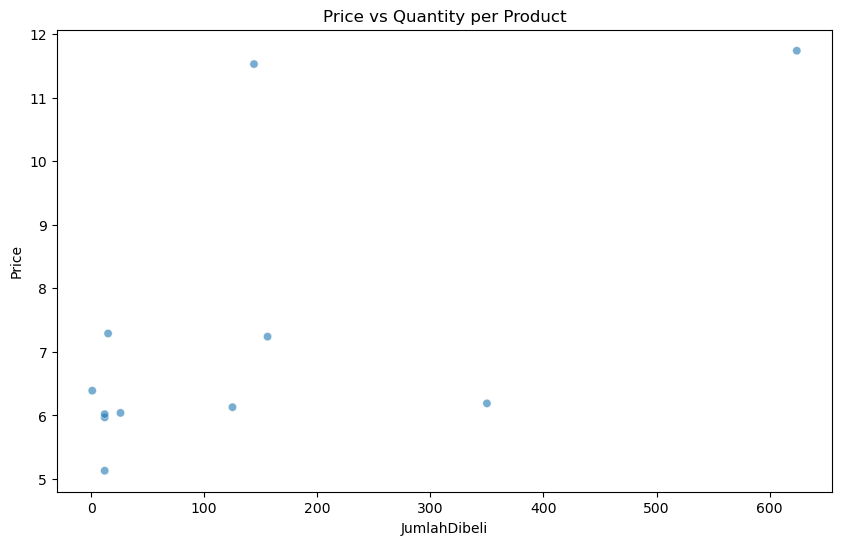

In [225]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=most_correlated, x='JumlahDibeli', y='Price', hue='ProductName', alpha=0.6, legend=False)
plt.title("Price vs Quantity per Product")
plt.show()

#### 3.1.5 Basket Size

3.1.5.1 Hitung rata-rata basket size dari seluruh transaksi per harinya, apakah konsisten atau ada perubahan?

In [226]:
tren_aov_harian.head()

,Date,AvgAOV,MAAvgAOV
0,2019-01-04,2222.0,NaN
1,2019-01-05,2344.0,NaN
2,2019-01-06,2174.0,NaN
3,2019-01-07,2158.0,NaN
4,2019-01-09,1719.0,NaN


3.1.5.2 Apakah ada perbedaan ukuran basket dari negara yang berbeda ?

In [227]:
negara_nonuk[['Country', 'TotalRevenue', 'CountTransaksi', 'AOV']].head()

,Country,TotalRevenue,CountTransaksi,AOV
14,Germany,818003.27,373,2193.038257
13,France,746512.1,335,2228.394328
10,EIRE,515093.53,186,2769.320054
3,Belgium,180859.74,85,2127.761647
29,Spain,148977.28,63,2364.71873


### 3.2 Crusial Questions  
Ini adalah 5 pertanyaan utama yang ditanyakan oleh pembuat dataset sales ini.  

1. How was the sales trend over the months?

In [228]:
seasonality_month_transaction = df_normal.groupby('PurchaseMonth')['TransactionNo'].nunique().reset_index(name='JumlahTransaksi')

In [229]:
seasonality_month_revenue = df_normal.groupby('PurchaseMonth')['TotalRevenue'].sum().reset_index()

In [230]:
seasonality_month = seasonality_month_transaction.merge(seasonality_month_revenue, on = 'PurchaseMonth', how = 'left').reset_index()

In [231]:
seasonality_month['PurchaseMonth'] = pd.Categorical(
    seasonality_month['PurchaseMonth'],
    categories = month_order,
    ordered = True
)

In [232]:
seasonality_month = seasonality_month.sort_values('PurchaseMonth')

In [233]:
seasonality_month['AOV'] = (seasonality_month['TotalRevenue']/seasonality_month['JumlahTransaksi']).round()

In [234]:
seasonality_month.head()

,index,PurchaseMonth,JumlahTransaksi,TotalRevenue,AOV
4,4,January,951,1832051.29,1926.0
3,3,February,1005,1920077.84,1911.0
7,7,March,1321,2569020.44,1945.0
0,0,April,1140,2169414.49,1903.0
8,8,May,1560,2941742.06,1886.0


In [235]:
seasonality_month_transaction = df_normal.groupby('PurchaseMonth')['TransactionNo'].nunique().reset_index(name='JumlahTransaksi')

In [236]:
seasonality_month_revenue = df_normal.groupby('PurchaseMonth')['TotalRevenue'].sum().reset_index()

In [237]:
seasonality_month = seasonality_month_transaction.merge(seasonality_month_revenue, on = 'PurchaseMonth', how = 'left').reset_index()

In [238]:
seasonality_month['PurchaseMonth'] = pd.Categorical(
    seasonality_month['PurchaseMonth'],
    categories = month_order,
    ordered = True
)

In [239]:
seasonality_month = seasonality_month.sort_values('PurchaseMonth')

In [240]:
seasonality_month

,index,PurchaseMonth,JumlahTransaksi,TotalRevenue
4,4,January,951,1832051.29
3,3,February,1005,1920077.84
7,7,March,1321,2569020.44
0,0,April,1140,2169414.49
8,8,May,1560,2941742.06
6,6,June,1411,2647611.73
5,5,July,1284,2428644.36
1,1,August,1194,2507013.77
11,11,September,1584,3500338.1
10,10,October,1759,3683991.13


2.  What are the most frequently purchased products?

In [241]:
most_purchased_product = df_normal.groupby('ProductName')['TransactionNo'].nunique().reset_index(name='JumlahTransaksi').sort_values('JumlahTransaksi', ascending=False)

In [242]:
most_purchased_product.head()

,ProductName,JumlahTransaksi
798,Cream Hanging Heart T-Light Holder,1756
1621,Jumbo Bag Red Retrospot,1574
2565,Regency Cakestand 3 Tier,1442
2160,Party Bunting,1385
200,Assorted Colour Bird Ornament,1177


3.  How many products does the customer purchase in each transaction?

=> x = grouping by TransactionNo with ProductNo .nunique()  
=> x['ProductNo'].mean() [liat juga max min] 

In [243]:
basket_sze_product = df_normal.groupby('TransactionNo')['ProductNo'].nunique().reset_index(name='JenisProduk')

In [244]:
basket_sze_product = basket_sze_product.sort_values('JenisProduk', ascending=False)

In [245]:
basket_sze_product['JenisProduk'].describe()

count    16414.000000
mean        21.282442
std         26.045855
min          1.000000
25%          6.000000
50%         15.000000
75%         26.000000
max        291.000000
Name: JenisProduk, dtype: float64

4. What are the most profitable segment customers?

In [246]:
profitable_segment

,MonetarySegment,TotalRevenue,Customer,Percentage
3,Top,21285890.99,1097,68.0
0,High,6245784.28,1097,20.0
2,Mid,2847667.39,1097,9.0
1,Low,908894.8,1097,3.0


## 4. Conclusions and Recommendations